In [1]:
import numpy as np
import pandas as pd

In [2]:
from scipy.stats import chi2_contingency
import statsmodels as sts
from scipy import stats

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('../All_data_files/total_data_set.csv')

Первая гипотеза, которую я буду проверять: Игры определенных жанров (например, ролевые игры или экшены)
получают более высокие оценки, чем игры других жанров

Я буду использовать данные по признакам: score, Game_genre_rate, Prop_of_genre_on_platf, Mean_score_per_genre
Я хочу посмотреть как выглядядт распределения моих переменных

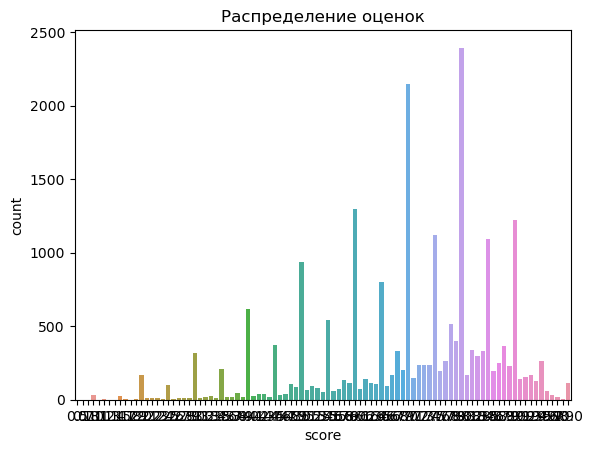

6.997749241185982


In [6]:
sns.countplot(df['score'])
plt.title("Распределение оценок")
plt.show()
print(df.score.mean())
# Похоже на нормальное, надо будет проверить

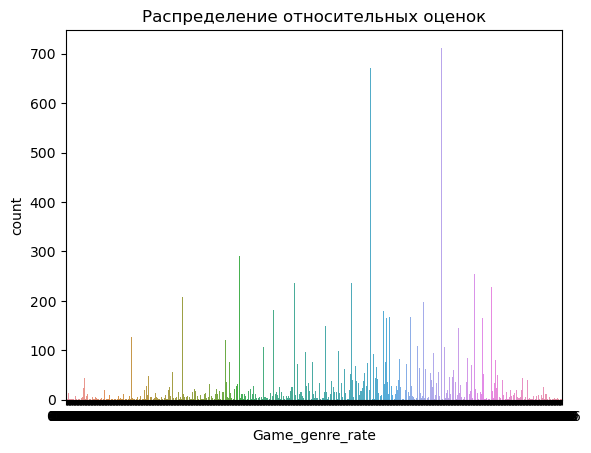

1.0038032220406017


In [7]:
sns.countplot(df['Game_genre_rate'])
plt.title("Распределение относительных оценок")
plt.show()
print(df.Game_genre_rate.mean())
# ОООооочень отдаленно похоже на нормальное, тоже проверю, но выглядит плохо(

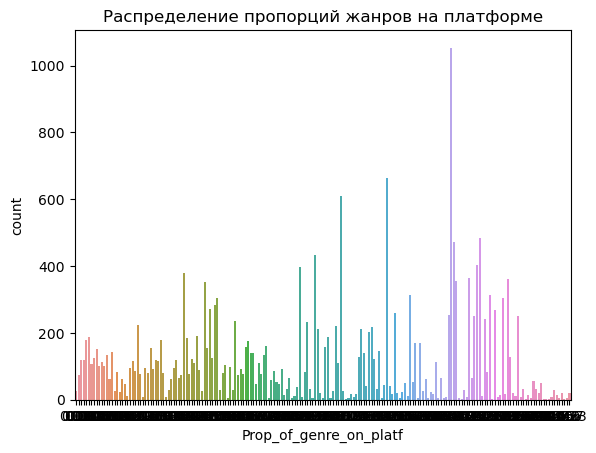

0.13166845668924168


In [8]:
sns.countplot(df['Prop_of_genre_on_platf'])
plt.title("Распределение пропорций жанров на платформе")
plt.show()
print(df.Prop_of_genre_on_platf.mean())
# Выглядит странно. Прсто всё как-то равномерно

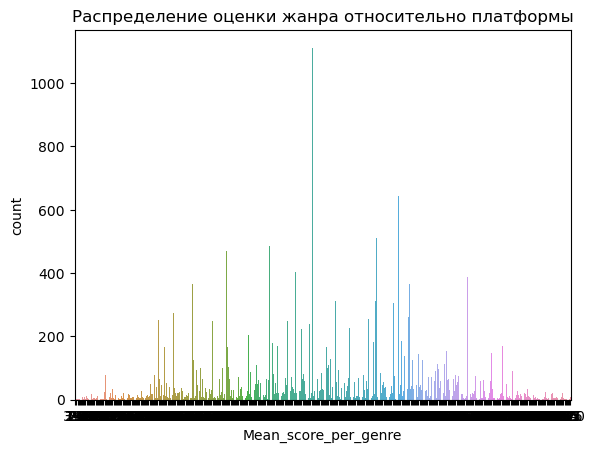

6.9517209899603385


In [9]:
sns.countplot(df['Mean_score_per_genre'])
plt.title("Распределение оценки жанра относительно платформы")
plt.show()
print(df.Mean_score_per_genre.mean())
# Какими-то общими чертами выглядит нормально. Ну будем смотреть

Перед началом проверки гипотез, я хочу убедиться, что score не независим относительно других переменных
Буду проверять на жанре, платформе, месяце и трех новых признаках. Для этого использую критерий хи-квадрат Пирсона

In [10]:
# Вот тут связь норм
print(chi2_contingency(df[['score', 'release_month']])[1])

2.285277859786888e-88


а с новыми признаками везде 1.0. Казалось бы, это говорит о том, что связи между переменными нет
Но я то знаю, что она есть...
Я проведу t-test для парных выборок. У меня вышло значение p-value где-то 0.0
Это значит, что существует статистически значимая разница между средними значениями двух выборок,
а это значит, что между переменными есть косвенная связь. Вот, теперь всё хорошо.

In [16]:
print(stats.ttest_rel(df['score'], df['Game_genre_rate']))
print(stats.ttest_rel(df['score'], df['Prop_of_genre_on_platf']))

TtestResult(statistic=605.074526574034, pvalue=0.0, df=21414)
TtestResult(statistic=595.4174466816777, pvalue=0.0, df=21414)


Для Mean_score_per_genre p-value = 2.210970105137794e-05. По идее, это говорит, что статистически значимая разница есть
и всё хорошо, но на всякий случая я проверю еще раз через корреляцию пирсона

In [19]:
print(stats.ttest_rel(df['score'], df['Mean_score_per_genre']))

TtestResult(statistic=4.243386887929145, pvalue=2.210970105137794e-05, df=21414)


In [20]:
print(df[['score', 'Mean_score_per_genre']].corr())

                        score  Mean_score_per_genre
score                 1.00000               0.33636
Mean_score_per_genre  0.33636               1.00000


Для категориальных переменных:
https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables

In [21]:
tab = pd.crosstab(df["score"], df["genre"])

Значение p-value меньше 0.05, значит всё ок, гипотеза о том, что переменные не связаны отвергается

In [22]:
print(0.05 > chi2_contingency(tab)[1])

True


In [23]:
tab1 = pd.crosstab(df["score"], df["platform"])
print(0.05 > chi2_contingency(tab1)[1])

True


Я проверила, что все мои переменные связаны, значит теперь можно начинать проверять остальные гипотезы.

Гипотеза 1:
Игры определенных жанров (например, ролевые игры или экшены) получают более высокие оценки, чем игры других жанров

Нулевая гипотеза будет звучать так
Н0: Средние оценки игры конкретного жанра выше, чем средние по другим жанрам
H1: Средние оценки игры этого жанра ниже, чем средние по другим

Так как я буду сравнивать средние значения групп, я буду использовать т-тест для независимых выборок
Первым делом я поделю все игры на двсе группы: в первой группе будут игры только одного жанра,
в другой все остальные жанры.

In [24]:
persp_gen = []
non_persp_gen = []

Выше у меня списки жанров, где первый - это "перспективные" жанры, которые в среднем получают более высокие оценки
и соответственно "неперспективные".

In [25]:
for i in df['genre'].unique():
    one = df[df['genre'] == i]['score']
    other = df[df['genre'] != i]['score']
    res = stats.ttest_ind(one, other, alternative="greater")
    # Если True, то средние оценки этого жанра в среднем выше, чем средние по другим жанрам
    if 0.05 < res[1]:
        persp_gen.append(i)
    else:
        non_persp_gen.append(i)

In [26]:
print(persp_gen)
print(non_persp_gen)

['Action', 'Bandai Namco Games', 'Sports', 'PlayStation 4', 'Adventure', 'Wrestling', 'Ubisoft', 'Racing', 'Fighting', 'Music', 'Sci-Fi', 'Dungeons and Dragons [D&D]', 'Theater', 'Horror', 'Number Of Players', 'Simulation', 'Boxing', 'Square Enix', 'Superhero', 'Electronic Arts', 'CyberConnect2', 'Animation', 'DC Comics', 'Comedy', 'Educational', 'Drama', 'Valve', 'Marvel Comics', 'Independent', 'Party', 'Thriller', 'IGN', 'Adult Swim Digital', 'Dark Horse', 'Board', 'Flight', 'Productivity', 'Battle', 'Card', 'Pinball', 'Hunting', 'Casino', 'Trivia', 'Other', 'Virtual Pet', 'Adult', 'Baseball']
['iPhone', 'RPG', 'Puzzle', 'Shooter', 'PC', 'SEGA', 'Compilation', 'Hardware', 'Platformer', 'Strategy', 'Riot Games', 'Skybound']


Итак, я получила список жанров, которые в среднем получают более высокие оценки по сравнению с другими жанрами.
Это именно то, что я и хотела.

Гипотеза 2
Игры, выпущенные на определенных платформах (например, ПК или консоли),
получают более высокие оценки, чем игры, выпущенные на других платформах
H0: Средние оценки игры на конкретной платформе выше, чем средние по другим платформам
H1: Средние оценки игры на конкретной платформе ниже, чем средние по другим платформам

In [27]:
persp_platf = []
non_persp_platf = []

In [28]:
for i in df['platform'].unique():
    one = df[df['platform'] == i]['score']
    other = df[df['platform'] != i]['score']
    res = stats.ttest_ind(one, other, alternative="greater")
    # Если True, то средние оценки на этой платформе в среднем выше, чем средние на других платформах
    if 0.05 < res[1]:
        persp_platf.append(i)
    else:
        non_persp_platf.append(i)

In [29]:
print(persp_platf)
print(non_persp_platf)

['iPod', 'Meta Quest 2', 'Nintendo Switch', 'Xbox Series X|S', 'PlayStation 5', 'On-Demand', 'Hardware', 'SteamOS', 'Stadia', 'iPhone 15 Pro', 'Blu-ray', 'Apple TV', 'DVD', 'Arcade', 'Luna', 'Theater', 'Meta Quest 3', 'Genesis', 'Sega CD', 'Meta Quest', 'Print', 'PlayStation 2', 'GameCube', 'Nintendo DS', 'Wii', 'PlayStation Portable', 'PlayStation', 'Nintendo 64', 'Saturn', 'Lynx', 'Game Boy Color', 'NeoGeo Pocket Color', 'Game.Com', 'Dreamcast VMU', 'WonderSwan', 'Nintendo 64DD', 'WonderSwan Color', 'Game Boy Advance', 'DVD / HD Video Game', 'Pocket PC', 'N-Gage', 'NES', 'TurboGrafx-16', 'NeoGeo', 'Master System', 'Atari 5200', 'TurboGrafx-CD', 'Atari 2600', 'Sega 32X', 'Vectrex', 'Commodore 64/128', 'Nintendo DSi', 'Windows Phone', 'Web Games', 'Windows Surface', 'Ouya', 'New Nintendo 3DS']
['PlayStation 4', 'Xbox One', 'PlayStation Vita', 'iPad', 'iPhone', 'Wii U', 'PC', 'Android', 'Macintosh', 'Meta Quest Pro', 'Linux', 'PlayStation 3', 'Nintendo 3DS', 'Xbox 360', 'Game Boy', 'Dre

Гипотеза 3
Игры (жанры), которых на конкретной больше, в среднем получают более высокие оценки
H0: Средние оценки игры жанра которого на платформе больше, выше, чем у игр других жанров
H1: Средние оценки игры жанра которого на платформе больше, ниже, чем у игр других жанров

In [30]:
persp_platf_prop_gen = []
non_persp_platf_prop_gen = []

In [31]:
for i in df['genre'].unique():
    one = df[df['genre'] == i]['score'] * df[df['genre'] == i]['Prop_of_genre_on_platf']
    other = df[df['genre'] != i]['score'] * df[df['genre'] != i]['Prop_of_genre_on_platf']
    res = stats.ttest_ind(one, other, alternative="greater")
    # Если True, то средние оценки этого жанра в среднем выше, чем средние по другим жанрам
    if 0.05 < res[1]:
        persp_platf_prop_gen.append(i)
    else:
        non_persp_platf_prop_gen.append(i)

In [32]:
print(persp_platf_prop_gen)
print(non_persp_platf_prop_gen)

['iPhone', 'Bandai Namco Games', 'Sports', 'PlayStation 4', 'RPG', 'Adventure', 'Puzzle', 'Wrestling', 'Shooter', 'PC', 'Ubisoft', 'Racing', 'Fighting', 'Music', 'SEGA', 'Sci-Fi', 'Compilation', 'Dungeons and Dragons [D&D]', 'Theater', 'Horror', 'Number Of Players', 'Simulation', 'Boxing', 'Square Enix', 'Superhero', 'Electronic Arts', 'Platformer', 'Strategy', 'Riot Games', 'CyberConnect2', 'Animation', 'Comedy', 'Educational', 'Drama', 'Valve', 'Independent', 'Party', 'Thriller', 'IGN', 'Adult Swim Digital', 'Dark Horse', 'Board', 'Flight', 'Productivity', 'Battle', 'Card', 'Pinball', 'Hunting', 'Casino', 'Trivia', 'Other', 'Virtual Pet', 'Adult', 'Baseball']
['Action', 'Hardware', 'Skybound', 'DC Comics', 'Marvel Comics']


Тепреь интересно посмотреть, есть ли пересечения с жанрами из гипотезы 1.
Получается, что в этом списке те жанры, которые получаются наиболее высокие оценки относительно других жанров в целом
И при своем численном преимуществе на какой-либо платформе

In [33]:
print(list(set(persp_gen) & set(persp_platf_prop_gen)))

['Electronic Arts', 'Dungeons and Dragons [D&D]', 'Trivia', 'Productivity', 'Theater', 'Flight', 'Casino', 'Drama', 'CyberConnect2', 'Pinball', 'Thriller', 'Independent', 'Adult Swim Digital', 'Superhero', 'Square Enix', 'Adventure', 'IGN', 'Sports', 'Music', 'PlayStation 4', 'Boxing', 'Comedy', 'Animation', 'Educational', 'Sci-Fi', 'Virtual Pet', 'Number Of Players', 'Party', 'Other', 'Bandai Namco Games', 'Adult', 'Card', 'Fighting', 'Simulation', 'Racing', 'Dark Horse', 'Wrestling', 'Hunting', 'Valve', 'Baseball', 'Ubisoft', 'Battle', 'Horror', 'Board']


Гипотеза 4
Для предыдущих гипотез я рассмотрела отдельно популярность жанров и платформ. А если посмотреть их в комбинации?
Гипотеза: Средняя оценка по жанру и платформе различается для разных комбинаций жанра и платформы.
Я решила, что попробую реализовать Тест Крускала-Уоллиса, потому что она позволяет взять как
переменные-предикторы категориальные переменные и при этом не требует нормальность распределений
При анализе я хочу учесть, пропорцию жанра на платформе (Prop_of_genre_on_platf),
ее среднюю оценку относительно других жанров на платформе (Mean_score_per_genre),
и оценку каждой игры относительно ее жанра в целом (Game_genre_rate).

Алгоритм беру отсюда: https://www.codecamp.ru/blog/kruskal-wallis-test-python/

H0: оценка игры не зависит от комбинации факторов (три новые переменные + жанр + платформа)
H1: Средняя оценка конкретного жанра на конкретной платформе выше,
чем если бы игра этого жанра вышла на другой платформе

In [34]:
# Я поняла, что мне нужно преобразовать таки жанр и платформу в числовой формат для этого теста.
df["genre"] = df["genre"].astype("category").cat.codes # делаю кодирование по порядку
df["platform"] = df["platform"].astype("category").cat.codes # аналогично

In [35]:
factors = ["Game_genre_rate", "Prop_of_genre_on_platf", "Mean_score_per_genre", 'genre', 'platform']

In [36]:
# тест Краскела-Уоллиса
print(stats.kruskal(df['genre'], df['platform'], df['Prop_of_genre_on_platf'], df['Game_genre_rate'],
                    df['Mean_score_per_genre'], df['score'])[1] < 0.05)

True


Следовательно я подтверждаю, что связь все таки есть, и имеет значение в каком жанре и на
какой платформе выпускать игру для большего успеха